## California Housing Prices

Este *dataset* contiene los precios medios de las viviendas en los distritos de California derivados del censo de 1990.

## Objetivo

Se tratarán dos modelos de Machine Learning sobre este dataset.

- Modelo predictor regresor del precio de las casas.
- Modelo de clusterización no supervisada.

## Referencia

Este dataset es un versión modificada del [Repositorio de StatLib](https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html), disponible para su descarga en [Kaggle](https://www.kaggle.com/datasets/camnugent/california-housing-prices?select=housing.csv).

## Librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_regression
from sklearn.ensemble import GradientBoostingClassifier, RandomForestRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (FunctionTransformer, OrdinalEncoder,
                                   StandardScaler)
from sklearn.tree import DecisionTreeRegressor

from utils.datascience import get_cardinality
from utils.vizdatatools import (plot_categorical_numerical_relationship,
                                plot_multiple_categorical_distributions,
                                plot_multiple_histograms_KDEs_boxplots)

## Vistazo técnico (y rápido de los datos)

En la documentación de este *dataset* encontramos la siguiente información:

1. longitude: Una medida de qué tan al oeste está una casa; un valor más alto indica más al oeste.
2. latitude: Una medida de qué tan al norte está una casa; un valor más alto indica más al norte.
3. housingMedianAge: Mediana de la edad de una casa dentro de un bloque; un número más bajo indica un edificio más nuevo.
4. totalRooms: Número total de habitaciones dentro de un bloque.
5. totalBedrooms: Número total de dormitorios dentro de un bloque.
6. population: Número total de personas que residen dentro de un bloque.
7. households: Número total de unidades familiares, un grupo de personas que residen dentro de una unidad de vivienda, para un bloque.
8. medianIncome: Mediana del ingreso de la unidad familiar dentro de un bloque de casas (medido en decenas de miles de dólares estadounidenses).
9. medianHouseValue: Mediana del valor de la vivienda para los hogares dentro de un bloque (medido en dólares estadounidenses).
10. oceanProximity: Ubicación de la casa con respecto al océano/mar.

In [2]:
df_housing = pd.read_csv('./data/california_housing_prices.csv')
df_housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [3]:
df_housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


## Machine Learning Supervisado: Regresor

Vamos a comenzar la parte de Machine Leaning Supervisado: Predicción del problema de las casas. Para ello lo primero que hacemos es el split de *train* y *test* de forma que no se contaminen los datos o realicemos sesgos.

### Split de train y test


In [4]:
# Split de train y test
random_state = 123
train_set, test_set = train_test_split(df_housing, test_size=0.2, random_state=random_state)

# Cuidado porque un random_state = 42 hace que no haya ningún valor missing en el train

### Mini-EDA

Para el problema de regresión numérica el *target* claramente será "median_house_value".

In [5]:
get_cardinality(train_set)

pandas.DataFrame shape:  (16512, 10)


,Card,%_Card,NaN_Values,%_NaN_Values,Type,Class
longitude,825,4.996366,0,0.0,float64,Numeric - Discrete
latitude,840,5.087209,0,0.0,float64,Numeric - Discrete
housing_median_age,52,0.314922,0,0.0,float64,Numeric - Discrete
total_rooms,5509,33.363614,0,0.0,float64,Numeric - Continuous
total_bedrooms,1823,11.040455,172,1.041667,float64,Numeric - Discrete
population,3675,22.256541,0,0.0,float64,Numeric - Discrete
households,1721,10.422723,0,0.0,float64,Numeric - Discrete
median_income,10953,66.333576,0,0.0,float64,Numeric - Continuous
median_house_value,3663,22.183866,0,0.0,float64,Numeric - Discrete
ocean_proximity,5,0.030281,0,0.0,object,Categoric


In [6]:
train_set.describe(include='all')

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
count,16512.000000,16512.000000,16512.000000,16512.000000,16340.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,<1H OCEAN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7329
mean,-119.566976,35.627757,28.570918,2648.943193,541.041493,1434.115734,502.672844,3.870716,206968.729530,NaN
std,2.000519,2.134543,12.582281,2208.372267,427.316722,1130.309986,387.541495,1.900132,115414.844601,NaN
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,NaN
25%,-121.800000,33.930000,18.000000,1453.000000,297.000000,789.000000,280.000000,2.562500,119400.000000,NaN
50%,-118.490000,34.250000,29.000000,2138.500000,438.000000,1170.000000,412.000000,3.529400,180400.000000,NaN
75%,-118.010000,37.710000,37.000000,3158.000000,650.000000,1735.000000,608.000000,4.750375,264725.000000,NaN


También puede ser interesante crear nuevas variables numéricas con mayor explicabilidad.


In [7]:
train_set["rooms_per_house"] = train_set["total_rooms"] / train_set["households"]
train_set["bedrooms_ratio"] = train_set["total_bedrooms"] / train_set["total_rooms"]
train_set["people_per_house"] = train_set["population"] / train_set["households"]

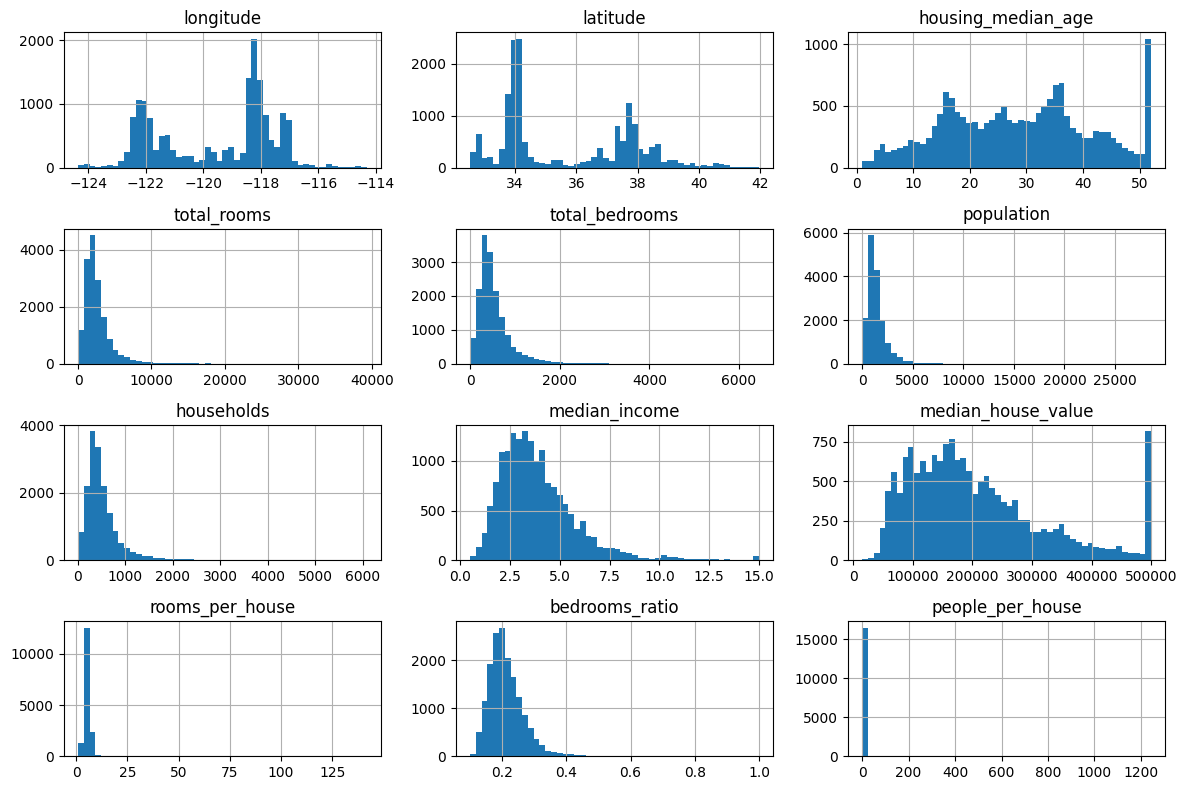

In [8]:
train_set.hist(bins=50, figsize=(12, 8)); 
plt.tight_layout()
plt.show()

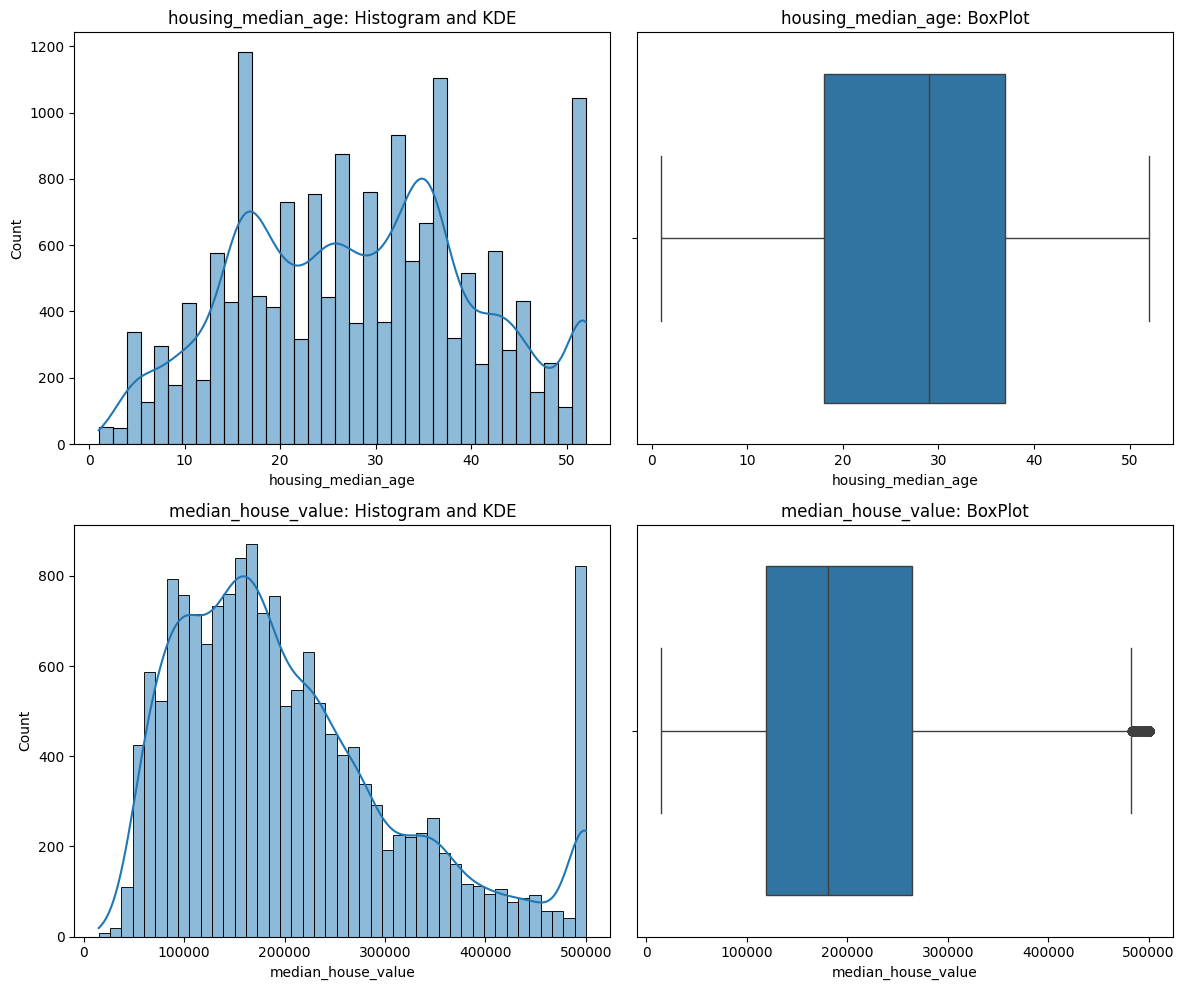

In [9]:
plot_multiple_histograms_KDEs_boxplots(train_set, ['housing_median_age', 'median_house_value'])

<Axes: >

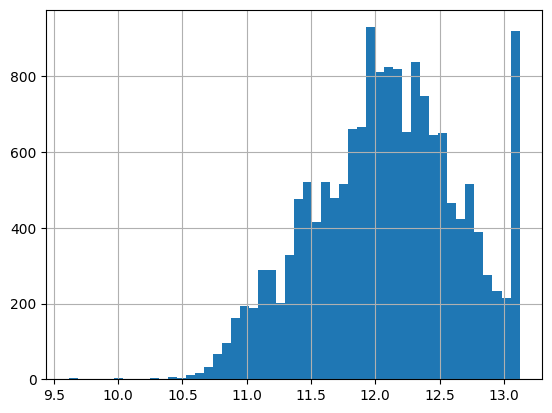

In [10]:
np.log(train_set['median_house_value']).hist(bins=50)

In [11]:
train_set['housing_median_age'].value_counts().sort_index(ascending=False).head()

housing_median_age
52.0    1006
51.0      38
50.0     111
49.0     110
48.0     134
Name: count, dtype: int64

In [12]:
train_set['median_house_value'].value_counts().sort_index(ascending=False).head()

median_house_value
500001.0    766
500000.0     22
499100.0      1
499000.0      1
498800.0      1
Name: count, dtype: int64

In [13]:
train_set['rooms_per_house'].value_counts().sort_index(ascending=False).head()

rooms_per_house
141.909091    1
132.533333    1
62.422222     1
59.875000     1
56.269231     1
Name: count, dtype: int64

In [14]:
train_set['bedrooms_ratio'].value_counts().sort_index(ascending=False).head()

bedrooms_ratio
1.000000    3
0.923077    1
0.922414    1
0.896552    1
0.780347    1
Name: count, dtype: int64

In [15]:
train_set['people_per_house'].value_counts().sort_index(ascending=False).head()

people_per_house
1243.333333    1
502.461538     1
230.172414     1
83.171429      1
51.400000      1
Name: count, dtype: int64

- Existen variables donde se han "capado" (puesto límite artificial) como "median_house_value" y "housing_median_age". Esto puede ser un problema porque el modelo puede aprender que no debe dar valores por encima de estos, pero para este ejemplo y sin la supervisión de "negocio", eliminaremos estos valores.

- Se ve que las escalas (ejes x) son muy diferentes como ya habíamos observado en los números.

- Hay muchas distribuciones tipo No-Gaussianas, desplazadas a la izquierda y con aparente larga cola. Normalizaremos los datos para que los modelos dependientes de ello funcionen mejor.
- "people_per_house" no parece tener mucho sentido. Son números demasiado altos para una única casa.

In [16]:
# Eliminar valores de "housing_median_age" mayores a 51,
# y valores de "median_house_value" mayores a 500000.0
# train_set = train_set[(train_set['housing_median_age'] < train_set['housing_median_age'].max())
#                       & (train_set['median_house_value'] < train_set['median_house_value'].max() )
#                       ]

# Eliminar valores de "housing_median_age" mayores a 50
# train_set = train_set[train_set['housing_median_age'] < train_set['housing_median_age'].max()]

Aparentemente solo hay una variable categórica: ocean_proximity.


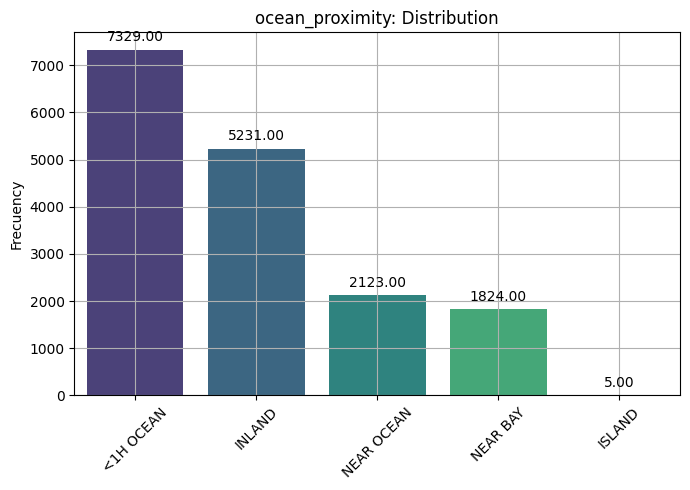

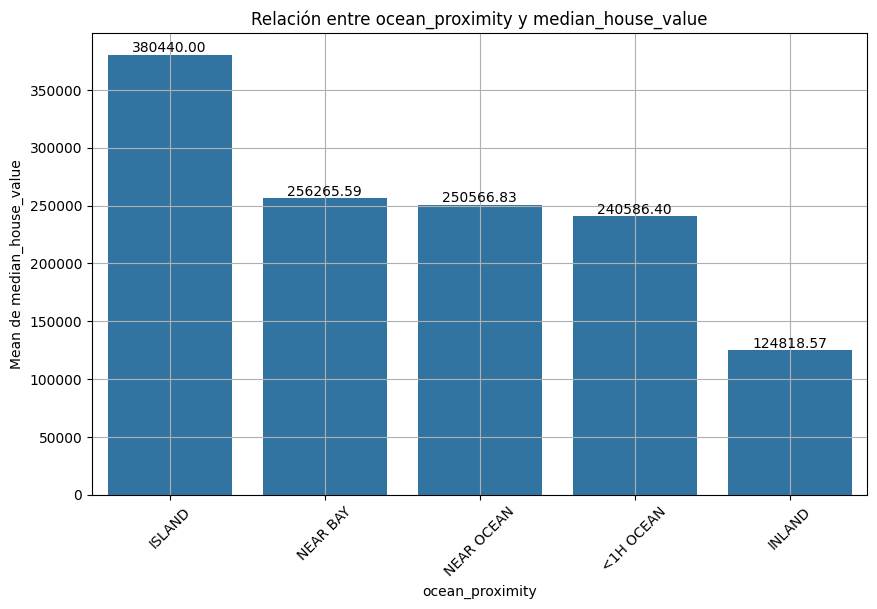

In [17]:
plot_multiple_categorical_distributions(train_set, ['ocean_proximity'], relative=False)
plot_categorical_numerical_relationship(train_set, 'ocean_proximity', 'median_house_value')

Parece interesante convertir "median_income" en una variable categórica, porque ya de por sí se ha intentado hacer un escalado con la misma. Vamos a recurrir a la función `cut` de pandas para ello.


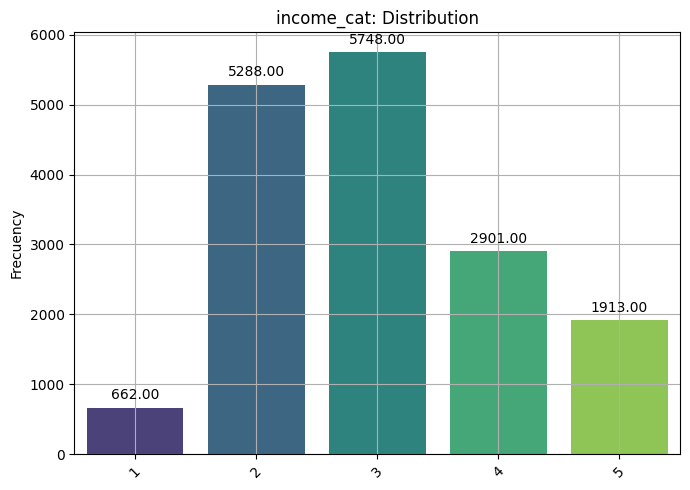

c:\Users\Lander\Documents\GitHub\ONLINE_DS_THEBRIDGE_2024\06_Deep_Learning\S18_Intro_Deep_Learning\Team_Challenge_Pipelines\utils\vizdatatools.py:447: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = df.groupby(categorical_col)[numerical_col].mean()


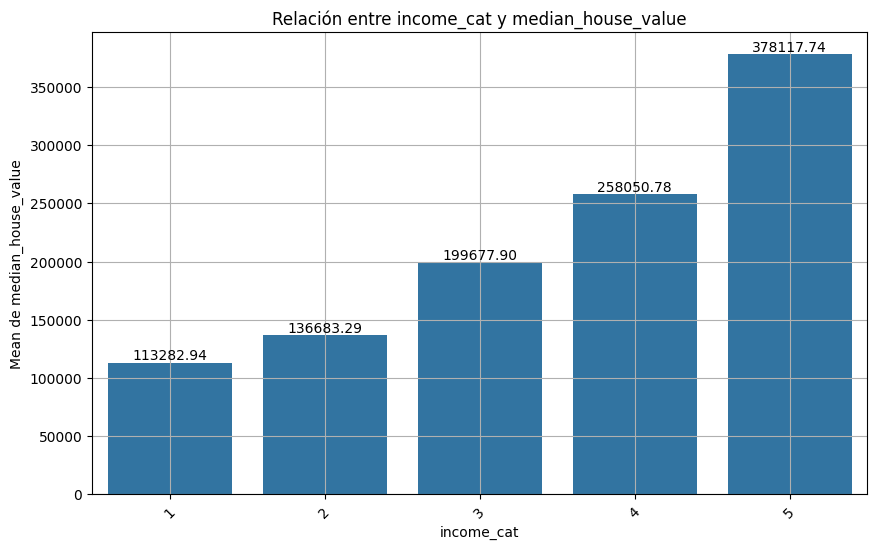

In [18]:
train_set['income_cat'] = pd.cut(train_set['median_income'],
                                 bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                 labels=[1, 2, 3, 4, 5]
                                 )

plot_multiple_categorical_distributions(train_set, ['income_cat'], relative=False)
plot_categorical_numerical_relationship(train_set, 'income_cat', 'median_house_value')

Ver las correlación con el *target*.

In [19]:
corr_matrix = train_set.corr(numeric_only= True)
corr_matrix["median_house_value"].sort_values(ascending = False)

median_house_value    1.000000
median_income         0.688904
rooms_per_house       0.150165
total_rooms           0.132965
housing_median_age    0.099487
households            0.064043
total_bedrooms        0.048823
people_per_house     -0.019762
population           -0.024484
longitude            -0.038349
latitude             -0.150574
bedrooms_ratio       -0.255369
Name: median_house_value, dtype: float64

Por la baja correlación con el target de: households, total_bedrooms, people_per_house, y population estas son variables que no vamos a usar para el modelo

### Tratamiento de features

El tratammiento de features se va a hacer mediante Pipelines de scikit-learn.

Con este escueto mini-EDA, y como conocemos ya un poco el dataset, estas son las transformaciones que vamos a realizar en el "train_set", y después en el "test_set". Todo ello se va a hacer a través de Pipelines.

- Eliminar valores missings, porque hay datos suficientes suficientes y no merece la pena pelearse en como rellenar los huecos. Los solo missings representan un 1% de los datos.
- Crear nuevas features más significativas y sencillas de comprender: *income_cat*, *rooms_per_house*, *bedrooms_ratio*.
- Target = *median_house_value*
- Definir features categóricas: *ocean_proximity* e *income_cat*.
- Definir features numéricas: latitude, housing_median_age, population, households, rooms_per_house, bedrooms_ratio
- Sobre *ocean_proximity* aplicar un OrdinalEncoder().
- Sobre population, households, rooms_per_house y bedrooms_ratio aplicar el logaritmo, para modificar su distribución y después aplicar un StandardScaler sobre todas las numéricas.
- El *target* tiene una distribución bastante adecuada, pero igualmente vamos a aplicarle el logaritmo para modificar su distribución. Después habrá que deshacer ese cambio.

In [29]:
random_state = 123
train_set, test_set = train_test_split(df_housing, test_size=0.2, random_state=random_state)

# Dividir el conjunto de datos en características y objetivo
X_train = train_set.drop('median_house_value', axis=1) 
y_train_log = np.log(train_set['median_house_value']) 
X_test = test_set.drop('median_house_value', axis=1) 
y_test_log = np.log(test_set['median_house_value']) 

# Función para crear nuevas features
def add_custom_features(X):
    X = X.copy()  # Evitar modificar el original
    X["rooms_per_house"] = X["total_rooms"] / X["households"]
    X["bedrooms_ratio"] = X["total_bedrooms"] / X["total_rooms"]
    return X

# Crear income_cat basado en bins
def create_income_cat(X):
    X = X.copy()
    X["income_cat"] = pd.cut(X["median_income"],
                             bins=[0, 1.5, 3.0, 4.5, 6, np.inf],
                             labels=[1, 2, 3, 4, 5])
    return X

# Features numéricas y categóricas
num_features = ['latitude', 'housing_median_age', 'population', 'households', 'rooms_per_house', 'bedrooms_ratio']
cat_features = ['ocean_proximity', 'income_cat']
columns_to_exclude = [col for col in X_train.columns if col not in (num_features + cat_features)]

# Pipeline para aplicar logaritmo solo a las columnas específicas
log_pipeline = Pipeline([
    ('log_transform', FunctionTransformer(lambda X: np.log(X), validate=False)),  # Aplicar logaritmo
])

# Pipeline para las variables numéricas (después de aplicar logaritmo)
num_pipeline = Pipeline([
    ('scaler', StandardScaler())  # Escalar
])

# Pipeline para las variables categóricas
categories = [["ISLAND", "NEAR OCEAN", "NEAR BAY", "<1H OCEAN", "INLAND"]]
oh_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder(categories=categories))  # Aplicar OrdinalEncoder con orden
])

# Crear el preprocesador que aplicará las transformaciones
preprocessor = ColumnTransformer([
    ('log', log_pipeline, ['population', 'households', 'rooms_per_house', 'bedrooms_ratio']), 
    ('num', num_pipeline, num_features),  
    ('cat', oh_pipeline, ['ocean_proximity']),
    ('excluye', 'drop', columns_to_exclude)  
])

# Pipeline completo para preprocesar los datos y luego entrenar el modelo
full_pipeline = Pipeline([
    ('remove_missing', FunctionTransformer(lambda X: X.dropna(), validate=False)), 
    ('add_num_features', FunctionTransformer(add_custom_features, validate=False)),  # Crear features
    ('add_cat_feature', FunctionTransformer(create_income_cat, validate=False)),  # Crear income_cat
    ('preprocessor', preprocessor)
])

# Aplicar el pipeline
X_train_prepared = full_pipeline.fit_transform(X_train)
X_test_prepared = full_pipeline.transform(X_test)


In [180]:
random_state = 123 
train_set, test_set = train_test_split(df_housing, test_size=0.2, random_state=random_state)

# Dividir el conjunto de datos en características y objetivo
X_train = train_set.drop('median_house_value', axis=1) 
y_train_log = np.log(train_set['median_house_value']) 
X_test = test_set.drop('median_house_value', axis=1) 
y_test_log = np.log(test_set['median_house_value']) 

# Función para crear nuevas features
def add_custom_features(X):
    X = X.copy()  # Evitar modificar el original
    X["rooms_per_house"] = X["total_rooms"] / X["households"]
    X["bedrooms_ratio"] = X["total_bedrooms"] / X["total_rooms"]
    return X

# Crear income_cat basado en bins
def create_income_cat(X):
    X = X.copy()
    X["income_cat"] = pd.cut(X["median_income"],
                             bins=[0, 1.5, 3.0, 4.5, 6, np.inf],
                             labels=[1, 2, 3, 4, 5])
    return X

# Features numéricas y categóricas
num_features = ['latitude', 'housing_median_age', 'population', 'households', 'rooms_per_house', 'bedrooms_ratio']
cat_features = ['ocean_proximity', 'income_cat']
columns_to_exclude = [col for col in X_train.columns if col not in (num_features + cat_features)]

# Pipeline para aplicar logaritmo solo a las columnas específicas
log_pipeline = Pipeline([
    ('log_transform', FunctionTransformer(lambda X: np.log(X), validate=False)),  # Aplicar logaritmo
])

# Pipeline para las variables numéricas (después de aplicar logaritmo)
num_pipeline = Pipeline([
    ('scaler', StandardScaler())  # Escalar
])

# Pipeline para las variables categóricas
categories = [["ISLAND", "NEAR OCEAN", "NEAR BAY", "<1H OCEAN", "INLAND"]]
oh_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder(categories=categories))  # Aplicar OrdinalEncoder con orden
])

# Crear el preprocesador que aplicará las transformaciones
preprocessor = ColumnTransformer([
    ('log', log_pipeline, ['population', 'households', 'rooms_per_house', 'bedrooms_ratio']), 
    ('num', num_pipeline, num_features),  
    ('cat', oh_pipeline, cat_features),
    ('excluye', 'drop', columns_to_exclude)  
])

# Pipeline completo para preprocesar los datos y luego entrenar el modelo
full_pipeline = Pipeline([
    ('remove_missing', FunctionTransformer(lambda X: X.dropna(), validate=False)), 
    ('add_num_features', FunctionTransformer(add_custom_features, validate=False)),  # Crear features
    ('add_cat_feature', FunctionTransformer(create_income_cat, validate=False)),  # Crear income_cat
    ('preprocessor', preprocessor)
])

full_pipeline.fit(X_train)

ValueError: Shape mismatch: if categories is an array, it has to be of shape (n_features,).

In [173]:
columns_to_exclude

['longitude', 'total_rooms', 'total_bedrooms', 'median_income']

In [ ]:




# Pipeline final que transforma los datos y aplica el modelo
def create_pipeline(model):
    return Pipeline([
        ('preprocessing', full_pipeline),
        ('model', model)
    ])

# Lista de modelos a probar
models = [
    Ridge(),
    RandomForestRegressor(),
    DecisionTreeRegressor()
]

# Evaluar cada modelo usando validación cruzada
for model in models:
    pipeline = create_pipeline(model)
    scores = cross_val_score(pipeline, X_train, y_train_log, cv=5, scoring='neg_mean_squared_error')
    rmse_scores = np.sqrt(-scores)
    print(f"Model: {model.__class__.__name__}, RMSE: {rmse_scores.mean():.2f}")


In [ ]:

# Dividir el conjunto de datos en entrenamiento y prueba
random_state = 123 
train_set, test_set = train_test_split(df_housing, test_size=0.2, random_state=random_state)

# Dividir el conjunto de datos en características y objetivo
X_train = train_set.drop('median_house_value', axis=1) 
y_train_log = np.log1p(train_set['median_house_value'])  # Usar log1p para la transformación

# Función para crear nuevas features
def add_custom_features(X):
    X = X.copy()  # Evitar modificar el original
    X["rooms_per_house"] = X["total_rooms"] / X["households"]
    X["bedrooms_ratio"] = X["total_bedrooms"] / X["total_rooms"]
    return X

# Crear income_cat basado en bins
def create_income_cat(X):
    X = X.copy()
    X["income_cat"] = pd.cut(X["median_income"],
                             bins=[0, 1.5, 3.0, 4.5, 6, np.inf],
                             labels=[1, 2, 3, 4, 5])
    return X

# Aplicar la creación de características antes de definir los pipelines
X_train = add_custom_features(X_train)
X_train = create_income_cat(X_train)

# Features numéricas y categóricas
num_features = ['latitude', 'housing_median_age', 'population', 'households', 'rooms_per_house', 'bedrooms_ratio']
cat_features = ['ocean_proximity', 'income_cat']

# Pipeline para las variables numéricas
num_pipeline = Pipeline([
    ('scaler', StandardScaler())  # Escalar
])

# Pipeline para las variables categóricas
categories = [["ISLAND", "NEAR OCEAN", "NEAR BAY", "<1H OCEAN", "INLAND"]]
oh_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder(categories=categories))  # Aplicar OrdinalEncoder con orden
])

# Crear el preprocesador que aplicará las transformaciones
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),  
    ('cat', oh_pipeline, cat_features)
])

# Pipeline completo para preprocesar los datos y luego entrenar el modelo
full_pipeline = Pipeline([
    ('remove_missing', FunctionTransformer(lambda X: X.dropna(), validate=False, feature_names_out='one-to-one')),  # Eliminar filas con valores faltantes
    ('preprocessor', preprocessor)
])

# Ajustar el pipeline completo a los datos
full_pipeline.fit(X_train, y_train_log)


In [ ]:
# Dividir el conjunto de datos en entrenamiento y prueba
random_state = 123 
train_set, test_set = train_test_split(df_housing, test_size=0.2, random_state=random_state)

# Crear nuevas columnas
train_set["rooms_per_house"] = train_set["total_rooms"] / train_set["households"]
train_set["bedrooms_ratio"] = train_set["total_bedrooms"] / train_set["total_rooms"]

In [ ]:




# Dividir el conjunto de datos en características y objetivo
X_train = train_set.drop('median_house_value', axis=1) 
y_train_log = np.log1p(train_set['median_house_value'])  # Usar log para la transformación

# Función para crear nuevas features
def add_custom_features(X):
    X = X.copy()  # Evitar modificar el original
    X["rooms_per_house"] = X["total_rooms"] / X["households"]
    X["bedrooms_ratio"] = X["total_bedrooms"] / X["total_rooms"]
    return X

# Crear income_cat basado en bins
def create_income_cat(X):
    X = X.copy()
    X["income_cat"] = pd.cut(X["median_income"],
                             bins=[0, 1.5, 3.0, 4.5, 6, np.inf],
                             labels=[1, 2, 3, 4, 5])
    return X

# Aplicar la creación de características antes de definir los pipelines
X_train = add_custom_features(X_train)
X_train = create_income_cat(X_train)

# Features numéricas y categóricas
num_features = ['latitude', 'housing_median_age', 'population', 'households', 'rooms_per_house', 'bedrooms_ratio']
cat_features = ['ocean_proximity', 'income_cat']
columns_to_exclude = [col for col in X]

# Pipeline para las variables numéricas
num_pipeline = Pipeline([
    ('scaler', StandardScaler())  # Escalar
])

# Pipeline para las variables categóricas
categories = [["ISLAND", "NEAR OCEAN", "NEAR BAY", "<1H OCEAN", "INLAND"]]
oh_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder(categories=categories))  # Aplicar OrdinalEncoder con orden
])

# Crear el preprocesador que aplicará las transformaciones
preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),  
    ('cat', oh_pipeline, cat_features)
])

# Pipeline completo para preprocesar los datos y luego entrenar el modelo
full_pipeline = Pipeline([
    ('remove_missing', FunctionTransformer(lambda X: X.dropna(), validate=False, feature_names_out='one-to-one')),  # Eliminar filas con valores faltantes
    ('preprocessor', preprocessor)
])

# Ajustar el pipeline completo a los datos
full_pipeline.fit(X_train, y_train_log)


In [27]:
random_state = 123 
train_set, test_set = train_test_split(df_housing, test_size=0.2, random_state=random_state)

# Crear nuevas columnas
train_set["rooms_per_house"] = train_set["total_rooms"] / train_set["households"]
train_set["bedrooms_ratio"] = train_set["total_bedrooms"] / train_set["total_rooms"]
train_set['income_cat'] = pd.cut(train_set['median_income'],
                                 bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                                 labels=[1, 2, 3, 4, 5]
                                 )

# Dividir el conjunto de datos en características y objetivo
X_train = train_set.drop('median_house_value', axis=1) 
y_train_log = np.log(train_set['median_house_value']) 
X_test = test_set.drop('median_house_value', axis=1) 
y_test_log = np.log(test_set['median_house_value']) 

# Features numéricas y categóricas
num_features = ['latitude', 'housing_median_age', 'population', 'households', 'rooms_per_house', 'bedrooms_ratio']
cat_features = ['ocean_proximity', 'income_cat']
columns_to_exclude = [col for col in X_train.columns if col not in (num_features + cat_features)]

# Pipeline para aplicar logaritmo solo a las columnas específicas
log_pipeline = Pipeline([
    ('log_transform', FunctionTransformer(lambda X: np.log(X), validate=False)),  # Aplicar logaritmo
])

# Pipeline para las variables numéricas (después de aplicar logaritmo)
num_pipeline = Pipeline([
    ('scaler', StandardScaler())  # Escalar
])

# Pipeline para las variables categóricas
categories = [["ISLAND", "NEAR OCEAN", "NEAR BAY", "<1H OCEAN", "INLAND"]]
oh_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder(categories=categories))  # Aplicar OrdinalEncoder con orden
])

# Crear el preprocesador que aplicará las transformaciones
preprocessor = ColumnTransformer([
    ('log', log_pipeline, ['population', 'households', 'rooms_per_house', 'bedrooms_ratio']), 
    ('num', num_pipeline, num_features),  
    ('cat', oh_pipeline, ['ocean_proximity']),
    ('excluye', 'drop', columns_to_exclude)  
])

# Pipeline completo para preprocesar los datos y luego entrenar el modelo
full_pipeline = Pipeline([
    ('remove_missing', FunctionTransformer(lambda X: X.dropna(), validate=False)), 
    ('preprocessor', preprocessor)
])

full_pipeline.fit(X_train)

Pipeline(steps=[('remove_missing',
                 FunctionTransformer(func=<function <lambda> at 0x0000021789CB2E80>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('log',
                                                  Pipeline(steps=[('log_transform',
                                                                   FunctionTransformer(func=<function <lambda> at 0x0000021789CB2660>))]),
                                                  ['population', 'households',
                                                   'rooms_per_house',
                                                   'bedrooms_ratio']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['latitude',
                                                   'housing_median_age',
                                                   'population', 'households',
                                                   'rooms_per_house',
                                                   'bedrooms_ratio']),
                                                 ('cat',
                                                  Pipeline(steps=[('ordinal',
                                                                   OrdinalEncoder(categories=[['ISLAND',
                                                                                               'NEAR '
                                                                                               'OCEAN',
                                                                                               'NEAR '
                                                                                               'BAY',
                                                                                               '<1H '
                                                                                               'OCEAN',
                                                                                               'INLAND']]))]),
                                                  ['ocean_proximity']),
                                                 ('excluye', 'drop',
                                                  ['longitude', 'total_rooms',
                                                   'total_bedrooms',
                                                   'median_income'])]))])

In [28]:
X_train

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity,rooms_per_house,bedrooms_ratio,income_cat
9950,-122.33,38.38,28.0,1020.0,169.0,504.0,164.0,4.5694,INLAND,6.219512,0.165686,4
3547,-118.60,34.26,18.0,6154.0,1070.0,3010.0,1034.0,5.6392,<1H OCEAN,5.951644,0.173871,4
4448,-118.21,34.07,47.0,1346.0,383.0,1452.0,371.0,1.7292,<1H OCEAN,3.628032,0.284547,2
6984,-118.02,33.96,36.0,2071.0,398.0,988.0,404.0,4.6226,<1H OCEAN,5.126238,0.192178,4
4432,-118.20,34.08,49.0,1320.0,309.0,1405.0,328.0,2.4375,<1H OCEAN,4.024390,0.234091,2
...,...,...,...,...,...,...,...,...,...,...,...,...
7763,-118.10,33.91,36.0,726.0,NaN,490.0,130.0,3.6389,<1H OCEAN,5.584615,NaN,3
15377,-117.24,33.37,14.0,4687.0,793.0,2436.0,779.0,4.5391,<1H OCEAN,6.016688,0.169191,4
17730,-121.76,37.33,5.0,4153.0,719.0,2435.0,697.0,5.6306,<1H OCEAN,5.958393,0.173128,4
15725,-122.44,37.78,44.0,1545.0,334.0,561.0,326.0,3.8750,NEAR BAY,4.739264,0.216181,3


In [61]:
random_state = 123 
train_set, test_set = train_test_split(df_housing, test_size=0.2, random_state=random_state)

# Dividir el conjunto de datos en características y objetivo
X_train = train_set.drop('median_house_value', axis=1) 
y_train_log = np.log(train_set['median_house_value'])  # Usar log1p para la transformación

# Función para crear nuevas features
def add_custom_features(X):
    X = X.copy()
    X["rooms_per_house"] = X["total_rooms"] / X["households"]
    X["bedrooms_ratio"] = X["total_bedrooms"] / X["total_rooms"]
    return X

# Crear income_cat basado en bins
def create_income_cat(X):
    X = X.copy()
    X["income_cat"] = pd.cut(X["median_income"],
                             bins=[0, 1.5, 3.0, 4.5, 6, np.inf],
                             labels=[0, 1, 2, 3, 4])
    return X

# Features numéricas y categóricas
num_features = ['latitude', 'housing_median_age', 'population', 'households', 'rooms_per_house', 'bedrooms_ratio']
cat_features = ['ocean_proximity', 'income_cat']
columns_to_exclude = [col for col in X_train.columns if col not in (num_features + cat_features)]

# Pipeline para aplicar logaritmo solo a las columnas específicas
log_pipeline = Pipeline([
    ('log_transform', FunctionTransformer(lambda X: np.log(X), validate=False)),  # Aplicar logaritmo
])

# Pipeline para las variables numéricas (después de aplicar logaritmo)
num_pipeline = Pipeline([
    ('scaler', StandardScaler()) 
])

# Pipeline para las variables categóricas
categories = [["ISLAND", "NEAR OCEAN", "NEAR BAY", "<1H OCEAN", "INLAND"]]
oh_pipeline = Pipeline([
    ('ordinal', OrdinalEncoder(categories=categories))  # Aplicar OrdinalEncoder con orden
])

# Crear el preprocesador que aplicará las transformaciones
preprocessor = ColumnTransformer([
    ('log', log_pipeline, ['population', 'households', 'rooms_per_house', 'bedrooms_ratio']),  # Aplicar logaritmo
    ('num', num_pipeline, num_features),  # Escalar el resto de las numéricas
    ('ord_encoder', oh_pipeline, ['ocean_proximity']),
    ('excluye', 'drop', columns_to_exclude)  # Excluir columnas
    ],
    remainder='passthrough')

# Pipeline completo para preprocesar los datos y luego entrenar el modelo
full_pipeline = Pipeline([
    ('remove_missing', FunctionTransformer(lambda X: X.dropna())), 
    ('add_num_features', FunctionTransformer(add_custom_features)),  
    ('add_cat_feature', FunctionTransformer(create_income_cat)), 
    ('preprocessor', preprocessor)
])

X_temp = full_pipeline.fit_transform(X_train)
pd.DataFrame(X_temp)


# Pipeline final que transforma los datos y aplica el modelo
# def create_pipeline(model):
#     return Pipeline([
#         ('preprocessing', full_pipeline),
#         ('model', model)
#     ])

# # Lista de modelos a probar
# models = [
#     Ridge(),
#     RandomForestRegressor(),
#     DecisionTreeRegressor()
# ]

# # Evaluar cada modelo usando validación cruzada
# for model in models:
#     pipeline = create_pipeline(model)
#     scores = cross_val_score(pipeline, X_train, y_train_log, cv=5, scoring='neg_mean_squared_error')
#     rmse_scores = np.sqrt(-scores)
#     print(f"Model: {model.__class__.__name__}, RMSE: {rmse_scores.mean():.2f}")


,0,1,2,3,4,5,6,7,8,9,10,11
0,6.222576,5.099866,1.827691,-1.797659,1.288626,-0.044779,-0.821305,-0.872342,0.313877,-0.814435,4.0,3.0
1,8.009695,6.941190,1.783668,-1.749444,-0.641461,-0.839239,1.393463,1.369652,0.208023,-0.674393,3.0,3.0
2,7.280697,5.916202,1.288690,-1.256858,-0.730470,1.464693,0.016525,-0.338902,-0.710202,1.219373,3.0,1.0
3,6.895683,6.001415,1.634372,-1.649335,-0.782001,0.590788,-0.393552,-0.253861,-0.118154,-0.361144,3.0,3.0
4,7.247793,5.793014,1.392373,-1.452046,-0.725785,1.623584,-0.025013,-0.449713,-0.553572,0.356028,3.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
16335,6.830874,5.855072,1.531399,-1.395006,-0.716416,1.146909,-0.448347,-0.395596,-0.316370,0.591141,4.0,1.0
16336,7.798113,6.658011,1.794537,-1.776725,-1.058397,-1.157022,0.886170,0.712516,0.233727,-0.754460,3.0,3.0
16337,7.797702,6.546785,1.784801,-1.753725,0.796735,-1.872035,0.885286,0.501202,0.210690,-0.687103,3.0,3.0
16338,6.329721,5.786897,1.555882,-1.531638,1.007546,1.226355,-0.770929,-0.454867,-0.271075,0.049578,2.0,2.0


In [55]:
# full_pipeline[:-1].get_feature_names_out()

full_pipeline.get_feature_names_out

<bound method Pipeline.get_feature_names_out of Pipeline(steps=[('remove_missing',
                 FunctionTransformer(func=<function <lambda> at 0x0000021789F54900>)),
                ('add_num_features',
                 FunctionTransformer(func=<function add_custom_features at 0x0000021789F56520>)),
                ('add_cat_feature',
                 FunctionTransformer(func=<function create_income_cat at 0x0000021789F562A0>)),
                ('preprocessor',
                 ColumnTransformer(transformers=[('log',
                                                  Pipe...
                                                                   StandardScaler())]),
                                                  ['latitude',
                                                   'housing_median_age',
                                                   'population', 'households',
                                                   'rooms_per_house',
                                          